In [31]:
from torch import abs, softmax, sqrt, tensor, topk


def gather(t, dim, i):
    dim += (dim < 0) * t.ndim
    return t.gather(dim, i.expand(*t.shape[:dim], i.shape[dim], *t.shape[dim + 1 :]))


def attn(Q, K, V, M):
    s = (Q @ K.transpose(-1, -2)) / sqrt(tensor(Q.shape[-1])) + M
    return softmax(s, dim=-1) @ V


def sparq_attn(Q, K, V, V_mean, M, r, k):
    # 1. Approximate attention scores using r largest components of Q
    i1 = topk(abs(Q), r, -1).indices
    Q_hat, K_hat = gather(Q, -1, i1), gather(K, -1, i1)
    scale = sqrt(
        Q.shape[-1]
        * abs(Q_hat).sum(dim=-1, keepdim=True)
        / abs(Q).sum(dim=-1, keepdim=True)
    )
    s_hat = softmax(Q_hat @ K_hat.transpose(-1, -2) / scale + M, dim=-1)

    # 2. Gather top k positions based on approximate attention scores & run attention
    i2 = topk(s_hat, k, -1).indices
    iKV = i2[..., 0, :, None]
    K, V, M = gather(K, -2, iKV), gather(V, -2, iKV), gather(M, -1, i2)
    y_ = attn(Q, K, V, M)

    # 3. Estimate the total score of the top k, and interpolate with V_mean
    alpha = gather(s_hat, -1, i2).sum(-1, keepdim=True)
    return alpha * y_ + (1 - alpha) * V_mean


Text(0.5, 0, 'Approx')

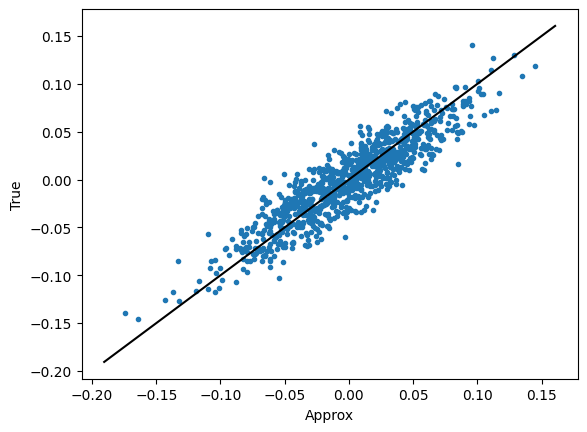

In [32]:
import torch
from torch import Tensor, rand, randn, zeros
import matplotlib.pyplot as plt

batch_size, n_head, context_size, head_size = 5, 3, 2048, 64
k, rank = 128, 32
mask_rate = 0.25

Q = randn(batch_size, n_head, 1, head_size)
K = randn(batch_size, n_head, context_size, head_size)
V = randn(batch_size, n_head, context_size, head_size)
M = -1e9 * (rand(batch_size, n_head, 1, context_size) < mask_rate)

original = attn(Q, K, V, M)
approx = sparq_attn(Q, K, V, V.mean(-2, keepdim=True), M, r=rank, k=k)
# approx2 = sparq_attn_new(Q, K, V, V.mean(-2, keepdim=True), M, r=rank, k=k)
# torch.testing.assert_close(approx, approx2)

plt.plot(approx.flatten(), original.flatten(), '.')
# plt.plot(approx2.flatten(), original.flatten(), '.')
xlim = plt.xlim()
plt.plot(xlim, xlim, "k-")
plt.ylabel("True")
plt.xlabel("Approx")